In [1]:
import numpy as np
import fitsio
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from time import time
import sys

sys.path.append('/global/homes/j/jmccull/sompz/')
from sompz import SelfOrganizingMap
from sompz import *
from sompz.som import *
#kernel imsimv2

# Make a simple SOM for COSMOS and XMM to fill with potential target selections

In [4]:
class SOM:
    def __init__(self, x, y, input_dim, learning_rate=0.5, sigma=6,random_start=False):
        self.x = x
        self.y = y
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.sigma = sigma if sigma is not None else max(x, y) / 2
        if random_start:
            self.weights = np.random.random((x, y, input_dim))
        else:
            self.weights = self._initialize_weights_grid()
        self.history = []
        self.history.append((np.NaN, self.weights.copy()))

    def _initialize_weights_grid(self):
        """Initialize weights in an equidistant grid."""
        # Create a grid of (x, y) coordinates
        xx, yy = np.meshgrid(np.linspace(0, 1, self.x), np.linspace(0, 1, self.y))
        # Flatten the grid coordinates and stack them
        grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)
        # If input_dim > 2, pad the remaining dimensions with zeros
        if self.input_dim > 2:
            grid = np.hstack([grid, np.random.random((self.x * self.y, self.input_dim - 2))])
        # Reshape the grid to (x, y, input_dim)
        return grid.reshape(self.x, self.y, self.input_dim)
        
    @classmethod
    def whiten_data(self,data,mode='linear',verbose=False):
        #will take data and turn it into a 0 to 1 range, and preserve the transformation bounds
        datalims = [np.nanmin(data,axis=0,keepdims=True).T,np.nanmax(data,axis=0,keepdims=True).T]
        if verbose:
            print(datalims[0].shape)
            print(datalims[1].shape)
        assert (datalims[1][:] - datalims[0][:] > 0).all()
        newdata = np.zeros_like(data)
            
        for i in np.arange(data.shape[1]):
            newdata[:,i] = (data[:,i] - datalims[0][i])/(datalims[1][i]- datalims[0][i])
        if mode == 'linear':
            return newdata, datalims
            
        if mode == 'log':
            for i in np.arange(data.shape[1]):
                newdata[:,i] = np.log(data[:,i]) 
            #newdata = newdata + 
        else:
            print("other data modes tbd, for now use 'linear'")
            
            return
        return newdata, datalims
    
    def train(self, data, num_iterations):
        for iteration in range(num_iterations):
            for i, sample in enumerate(data):
                bmu = self._find_bmu(sample)
                self._update_weights(sample, bmu, iteration, num_iterations)
            self.history.append((iteration, self.weights.copy()))
    
    def _find_bmu(self, sample):
        diff = self.weights - sample
        dist = np.linalg.norm(diff, axis=-1)
        return np.unravel_index(np.argmin(dist, axis=None), dist.shape)
    
    @staticmethod
    def find_bmu_custom(weights, sample):
        diff = weights - sample
        dist = np.linalg.norm(diff, axis=-1)
        return np.unravel_index(np.argmin(dist, axis=None), dist.shape)
    
    @staticmethod
    def get_occup(som,weights,samples):
        cells = np.zeros((som.x,som.y))
        for sample in samples:
            idx = SOM.find_bmu_custom(weights,sample)
            cells[idx]=cells[idx]+1
        return cells
    
    def _update_weights(self, sample, bmu, iteration, num_iterations):
        lr = self.learning_rate * (1 - iteration / num_iterations)
        sigma = self.sigma * (1 - iteration / num_iterations)
        bmu_x, bmu_y = bmu
        for x in range(self.x):
            for y in range(self.y):
                dist_to_bmu = np.linalg.norm([x - bmu_x, y - bmu_y])
                if dist_to_bmu <= sigma:
                    influence = np.exp(-dist_to_bmu**2 / (2 * (sigma**2)))
                    self.weights[x, y] += lr * influence * (sample - self.weights[x, y])

In [5]:
# let's train it on HSC photometry:
cosmos_deep_fname = '/global/cfs/cdirs/desi/users/bid13/DESI_II/target_data/HSC_COSMOS_I_mag_lim_24.8.fits'
xmm_deep_fname = '/global/cfs/cdirs/desi/users/bid13/DESI_II/target_data/HSC_XMM_I_mag_lim_24.8.fits'

In [6]:
cosmos_deep = fitsio.read(cosmos_deep_fname,ext=1)
print(cosmos_deep.shape)
print(cosmos_deep.dtype.names)

(2361974,)
('object_id', 'object_id_isnull', 'ra', 'ra_isnull', 'dec', 'dec_isnull', 'g_psfflux_flux', 'g_psfflux_flux_isnull', 'r_psfflux_flux', 'r_psfflux_flux_isnull', 'i_psfflux_flux', 'i_psfflux_flux_isnull', 'z_psfflux_flux', 'z_psfflux_flux_isnull', 'y_psfflux_flux', 'y_psfflux_flux_isnull', 'g_psfflux_fluxerr', 'g_psfflux_fluxerr_isnull', 'r_psfflux_fluxerr', 'r_psfflux_fluxerr_isnull', 'i_psfflux_fluxerr', 'i_psfflux_fluxerr_isnull', 'z_psfflux_fluxerr', 'z_psfflux_fluxerr_isnull', 'y_psfflux_fluxerr', 'y_psfflux_fluxerr_isnull', 'g_cmodel_flux', 'g_cmodel_flux_isnull', 'r_cmodel_flux', 'r_cmodel_flux_isnull', 'i_cmodel_flux', 'i_cmodel_flux_isnull', 'z_cmodel_flux', 'z_cmodel_flux_isnull', 'y_cmodel_flux', 'y_cmodel_flux_isnull', 'g_cmodel_fluxerr', 'g_cmodel_fluxerr_isnull', 'r_cmodel_fluxerr', 'r_cmodel_fluxerr_isnull', 'i_cmodel_fluxerr', 'i_cmodel_fluxerr_isnull', 'z_cmodel_fluxerr', 'z_cmodel_fluxerr_isnull', 'y_cmodel_fluxerr', 'y_cmodel_fluxerr_isnull', 'g_fiber_flux',

0


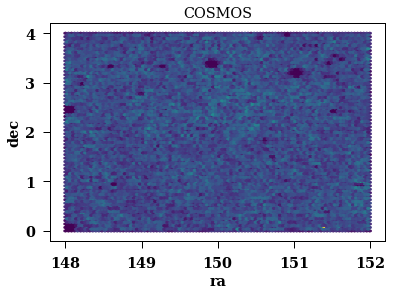

In [7]:
mask = (cosmos_deep['g_mask_brightstar_any'])&(cosmos_deep['r_mask_brightstar_any'])&(cosmos_deep['i_mask_brightstar_any'])&(cosmos_deep['z_mask_brightstar_any'])&(cosmos_deep['y_mask_brightstar_any'])
#& (cosmos_deep['g_mask_brightstar_halo'])& (cosmos_deep['g_mask_brightstar_dip'])& (cosmos_deep['g_mask_brightstar_ghost'])& (cosmos_deep['g_mask_brightstar_blooming'])
print(np.sum(~mask)/len(mask))
plt.hexbin(cosmos_deep[~mask]['ra'],cosmos_deep[~mask]['dec'])
plt.title('COSMOS')
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

cosmos_deep = cosmos_deep[mask]

(2331230,)
('object_id', 'object_id_isnull', 'ra', 'ra_isnull', 'dec', 'dec_isnull', 'g_psfflux_flux', 'g_psfflux_flux_isnull', 'r_psfflux_flux', 'r_psfflux_flux_isnull', 'i_psfflux_flux', 'i_psfflux_flux_isnull', 'z_psfflux_flux', 'z_psfflux_flux_isnull', 'y_psfflux_flux', 'y_psfflux_flux_isnull', 'g_psfflux_fluxerr', 'g_psfflux_fluxerr_isnull', 'r_psfflux_fluxerr', 'r_psfflux_fluxerr_isnull', 'i_psfflux_fluxerr', 'i_psfflux_fluxerr_isnull', 'z_psfflux_fluxerr', 'z_psfflux_fluxerr_isnull', 'y_psfflux_fluxerr', 'y_psfflux_fluxerr_isnull', 'g_cmodel_flux', 'g_cmodel_flux_isnull', 'r_cmodel_flux', 'r_cmodel_flux_isnull', 'i_cmodel_flux', 'i_cmodel_flux_isnull', 'z_cmodel_flux', 'z_cmodel_flux_isnull', 'y_cmodel_flux', 'y_cmodel_flux_isnull', 'g_cmodel_fluxerr', 'g_cmodel_fluxerr_isnull', 'r_cmodel_fluxerr', 'r_cmodel_fluxerr_isnull', 'i_cmodel_fluxerr', 'i_cmodel_fluxerr_isnull', 'z_cmodel_fluxerr', 'z_cmodel_fluxerr_isnull', 'y_cmodel_fluxerr', 'y_cmodel_fluxerr_isnull', 'g_fiber_flux',

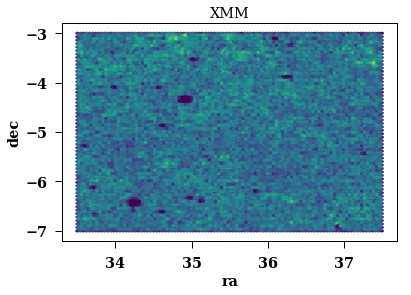

In [9]:
xmm_deep = fitsio.read(xmm_deep_fname,ext=1)
print(xmm_deep.shape)
print(xmm_deep.dtype.names)
mask = (xmm_deep['g_mask_brightstar_any'])&(xmm_deep['r_mask_brightstar_any'])&(xmm_deep['i_mask_brightstar_any'])&(xmm_deep['z_mask_brightstar_any'])&(xmm_deep['y_mask_brightstar_any'])

print(np.sum(~mask)/len(mask))
plt.hexbin(xmm_deep[~mask]['ra'],xmm_deep[~mask]['dec'])
plt.title('XMM')
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

xmm_deep = xmm_deep[mask]

# Now find the photometry to train a SOM
We have:
- 

/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


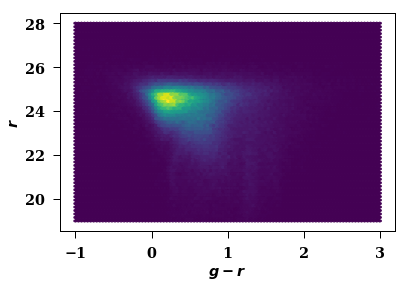

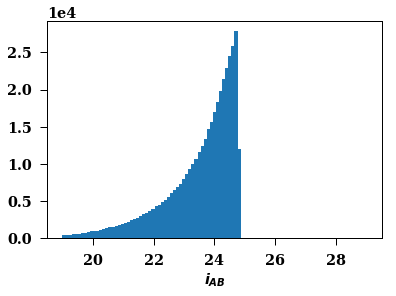

In [10]:
def abmags_nanojy(fluxes,zp=31.4):
    return zp - 2.5*np.log10(fluxes)
lims = (-1,3,19,28)
plt.hexbin(abmags_nanojy(xmm_deep['g_cmodel_flux']) - abmags_nanojy(xmm_deep['r_cmodel_flux']), abmags_nanojy(xmm_deep['r_cmodel_flux']),extent=lims)
plt.xlabel(r'$g - r$')
plt.ylabel(r'$r$')
plt.show()
plt.hist(abmags_nanojy(xmm_deep['i_cmodel_flux']),bins=np.linspace(19,29,num=100))
plt.xlabel(r'$i_{AB}$')
plt.show()

In [11]:
bands = ['g','r','i','z','y']
hsc_fluxcols = [band + '_cmodel_flux'for band in bands]
magcols = [band+'_mag' for band in bands]

hsc_fluxerrcols = [band + '_cmodel_fluxerr'for band in bands]
magerr = [band + '_magerr' for band in bands]

hsc_xmm_df = pd.DataFrame(xmm_deep.byteswap().newbyteorder(),columns=xmm_deep.dtype.names)

def get_mag_err(fluxerr,flux):
    snr = flux/fluxerr
    return (2.5/2.3)/snr

for i,band in enumerate(bands):
    print(i,band)
    hsc_xmm_df[magcols[i]] = abmags_nanojy(hsc_xmm_df[hsc_fluxcols[i]].values)
    hsc_xmm_df[magerr[i]] = get_mag_err(hsc_xmm_df[hsc_fluxerrcols[i]].values,hsc_xmm_df[hsc_fluxcols[i]].values)
    hsc_xmm_df[band + 'mag_ivar'] = 1/hsc_xmm_df[magerr[i]]**2
    
print(hsc_xmm_df.columns)

(0, 'g')
(1, 'r')
(2, 'i')
(3, 'z')
(4, 'y')
Index([u'object_id', u'object_id_isnull', u'ra', u'ra_isnull', u'dec',
       u'dec_isnull', u'g_psfflux_flux', u'g_psfflux_flux_isnull',
       u'r_psfflux_flux', u'r_psfflux_flux_isnull',
       ...
       u'rmag_ivar', u'i_mag', u'i_magerr', u'imag_ivar', u'z_mag',
       u'z_magerr', u'zmag_ivar', u'y_mag', u'y_magerr', u'ymag_ivar'],
      dtype='object', length=287)


/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in divide
  if sys.path[0] == '':


In [12]:
hsc_xmm_df

,object_id,object_id_isnull,ra,ra_isnull,dec,dec_isnull,g_psfflux_flux,g_psfflux_flux_isnull,r_psfflux_flux,r_psfflux_flux_isnull,...,rmag_ivar,i_mag,i_magerr,imag_ivar,z_mag,z_magerr,zmag_ivar,y_mag,y_magerr,ymag_ivar
0,36420386367222995,False,33.518648,False,-6.412665,False,808.848511,False,1115.296631,False,...,775.017578,22.787394,0.022414,1990.483032,22.457909,0.039320,646.793640,22.708813,0.096202,108.051613
1,36420394957161852,False,33.509134,False,-5.987075,False,167.254211,False,234.576324,False,...,22.906618,24.481548,0.051466,377.541901,24.253897,0.090543,121.981171,23.639736,0.122002,67.183571
2,36424634089881541,False,35.059176,False,-6.866507,False,1735.107056,False,6169.938965,False,...,11266.391602,21.115742,0.005430,33921.164062,20.793383,0.007343,18544.498047,20.658108,0.015218,4317.942871
3,36424638384847089,False,35.038240,False,-6.757763,False,253.415344,False,167.312424,False,...,10.310637,24.381847,0.124920,64.081711,23.277456,0.082736,146.087158,22.685715,0.161990,38.108513
4,36424646974785874,False,35.022919,False,-6.356621,False,408.300446,False,650.170715,False,...,341.880615,23.556566,0.036182,763.880920,23.691814,0.095608,109.399185,23.432091,0.166963,35.872410
5,36424646974787283,False,35.052156,False,-6.323747,False,362.007935,False,555.354126,False,...,189.593658,23.726683,0.032501,946.659973,23.373264,0.053495,349.437164,23.353699,0.129101,59.998962
6,36424646974789354,False,35.019848,False,-6.275541,False,490.997284,False,735.535889,False,...,256.337128,23.725954,0.064070,243.606003,23.613636,0.103683,93.022713,24.024105,0.313461,10.177322
7,36424646974790201,False,35.018313,False,-6.255265,False,298.002533,False,892.385559,False,...,448.070984,23.398232,0.025831,1498.686401,23.090652,0.039791,631.569946,22.880272,0.076548,170.661606
8,36424651269739250,False,35.015372,False,-6.111596,False,289.675720,False,404.931458,False,...,139.824570,24.075869,0.064574,239.820496,23.938581,0.130431,58.781219,24.183584,0.369846,7.310695
9,36424651269753478,False,35.048696,False,-6.159067,False,485.664520,False,611.112732,False,...,265.384247,23.968462,0.041990,567.170715,23.754564,0.083917,142.004120,23.706411,0.204562,23.897425


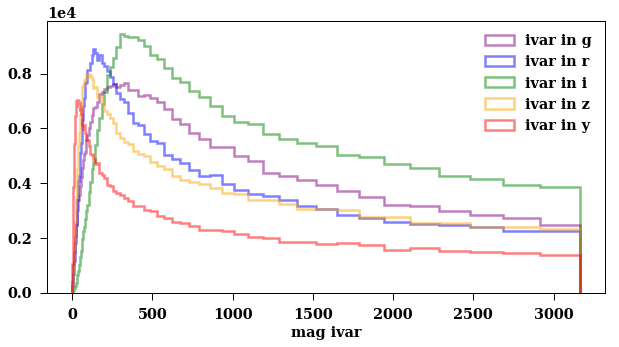

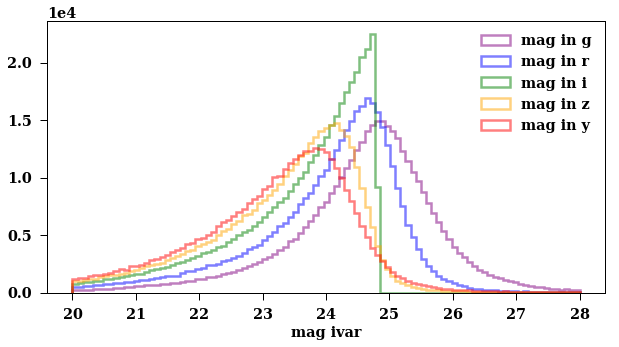

In [13]:
colors = ['purple','blue','green','orange','red']
plt.figure(figsize=(10,5))
for i,band in enumerate(bands):
    plt.hist(hsc_xmm_df[band+'mag_ivar'],alpha=0.5,histtype='step',bins=np.logspace(0,3.5,num=100),linewidth=2.5,color=colors[i],label = 'ivar in ' + band)
plt.xlabel('mag ivar')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10,5))
for i,band in enumerate(bands):
    plt.hist(hsc_xmm_df[band+'_mag'],alpha=0.5,histtype='step',bins=np.linspace(20,28,num=100),linewidth=2.5,color=colors[i],label = 'mag in ' + band)
plt.xlabel('mag ivar')
plt.legend(loc='upper right')
plt.show()

In [14]:
cols = [band +'_mag' for band in bands]
ivar_cols = [band+'mag_ivar' for band in bands]

#randomly sample the HSC data:
rand_ind = np.random.randint(0, len(hsc_xmm_df), size=1000, dtype=int).astype(int)


convert_dict = {'g_mag': float, 
                'r_mag': float, 
                'i_mag': float, 
                'z_mag': float, 
                'y_mag': float,
                'gmag_ivar': float, 
                'rmag_ivar': float, 
                'imag_ivar': float, 
                'zmag_ivar': float, 
                'ymag_ivar': float 
               } 
hsc_xmm_df.astype(convert_dict,inplace=True)
somvals = hsc_xmm_df.iloc[rand_ind][cols].values
som_ivar = hsc_xmm_df.iloc[rand_ind][ivar_cols].values
cols = cols+ivar_cols
data = hsc_xmm_df.iloc[rand_ind][cols].values
#sompz is causing problems, let's just do my simple som
som = SOM(x=10, y=10, input_dim=data.shape[1], random_start=True)

#whiten the data
print(data.shape)
data_one,datalims = som.whiten_data(data,mode='linear',verbose=True)
print(data_one)

(1000, 10)
(10, 1)
(10, 1)
[[2.5506574e-01 3.4437895e-01 9.0256727e-01 ... 6.0531449e-05
  2.5460433e-05 4.0106788e-05]
 [2.5112730e-01 2.9420987e-01 8.1821436e-01 ... 1.2346498e-04
  6.5766704e-05 2.0018602e-05]
 [1.0873679e-01 1.2790501e-01 3.4615219e-01 ... 2.3292452e-02
  1.4998464e-02 1.2902238e-02]
 ...
 [2.3905410e-01 2.9266655e-01 8.2211566e-01 ... 3.7213460e-05
  6.1560750e-05 2.6029742e-05]
 [2.1370685e-01 2.7184895e-01 7.2462505e-01 ... 2.9002459e-04
  1.6196123e-04 7.3664043e-05]
 [1.1624255e-01 1.1726947e-01 1.8284550e-01 ... 5.2843863e-01
  4.2347202e-01 8.9750493e-01]]


/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


In [15]:
start = time() #train the custom som with a small test
som.train(data_one, num_iterations=500)
print('time elapsed: {}'.format(time()-start))    

time elapsed: 407.193509817


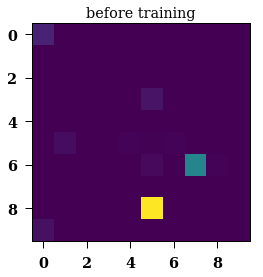

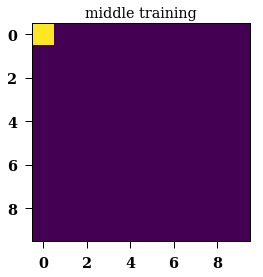

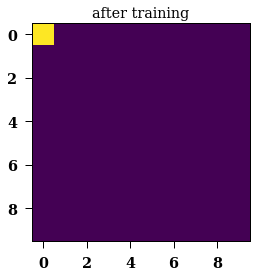

In [16]:
#look at the occupancy for a simple 10 by 10 som

#at the start:
it,weights = som.history[0]
#print(weights)
occup = som.get_occup(som,weights,data)
plt.imshow(occup.reshape(10,10))
plt.title('before training')
plt.show()

it,weights = som.history[1]
#print(weights)
occup = som.get_occup(som,weights,data)
plt.imshow(occup.reshape(10,10))
plt.title('middle training')
plt.show()

#at the end
it,weights = som.history[-1]
occup = som.get_occup(som,weights,data)

plt.imshow(occup.reshape(10,10))
plt.title('after training')
plt.show()

In [ ]:
som

In [ ]:
#som = train_som(somvals, som_ivar, map_shape=[10, 10], learning_rate=0.5, max_iter=1e3, min_val=1e-4, verbose=True, diag_ivar=False, replace=False)
"""Calculate Self Organizing Map

Parameters
----------
x :             input data of shape (n_samples, n_dim)
ivar :          inverse variance of input data (n_samples, n_dim, n_dim)
map_shape :     desired output map shape = [dim1, dim2]. (n_out_dim,)
learning_rate : float usually between 0 and 1. Sets how large of a
                change we can effect in the weights at each step by
                multiplying the change by:
                    learning_rate ** (step_t / total_t)
max_iter :      maximum number of steps in algorithm fit
min_val :       minimum parameter difference we worry about in updating
                SOM. This in practice usually doesn't come up, as we limit
                the range of cells a SOM may update to be less than one
                wrap around the map.
verbose :       Print updates?

Returns
-------
w : self organizing map weights (dim1, dim2, n_dims)

Notes
-----
Suggest whitening your data to span 0-1 range before training

"""

time elapsed: 7700.63557005


"Calculate Self Organizing Map\n\nParameters\n----------\nx :             input data of shape (n_samples, n_dim)\nivar :          inverse variance of input data (n_samples, n_dim, n_dim)\nmap_shape :     desired output map shape = [dim1, dim2]. (n_out_dim,)\nlearning_rate : float usually between 0 and 1. Sets how large of a\n                change we can effect in the weights at each step by\n                multiplying the change by:\n                    learning_rate ** (step_t / total_t)\nmax_iter :      maximum number of steps in algorithm fit\nmin_val :       minimum parameter difference we worry about in updating\n                SOM. This in practice usually doesn't come up, as we limit\n                the range of cells a SOM may update to be less than one\n                wrap around the map.\nverbose :       Print updates?\n\nReturns\n-------\nw : self organizing map weights (dim1, dim2, n_dims)\n\nNotes\n-----\nSuggest whitening your data to span 0-1 range before training\n